<a href="https://www.kaggle.com/code/naziraabdugani/notebook831aea6000?scriptVersionId=209801567" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Preprocessiong data

In [1]:
import h5py
import numpy as np
from torch.utils.data import Dataset

class SudokuDataset(Dataset):
    def __init__(self, h5_file_path, transform=None):
        self.h5_file_path = h5_file_path
        self.transform = transform

        # Load the HDF5 data
        with h5py.File(h5_file_path, 'r') as f:
            self.images = np.array(f['images'])  # Shape: (N, 84, 84)
            self.labels = np.array(f['labels'])  # Shape: (N,)
        if len(self.images) > len(self.labels):
            print(f"Trimming images from {len(self.images)} to {len(self.labels)} to match labels.")
            self.images = self.images[:len(self.labels)]
        
        #print(f"Number of images: {len(self.images)}, Number of labels: {len(self.labels)}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]  # Shape: (84, 84)
        label = self.labels[idx]  # Label

        # Reshape and normalize the image
        image = image.reshape(1, 84, 84).astype(np.float32) / 255.0  # Shape: (1, 84, 84)

        return image, label


In [2]:
import torch
from torch.utils.data import DataLoader, Subset
from collections import Counter
from torchvision import transforms

# Dataset transformation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load Dataset from separate files
train_file_path = '/kaggle/input/sudoku-images-based-on-mnist/sudoku_training_set.h5'  # Update with your training file path
val_file_path = '/kaggle/input/sudoku-images-based-on-mnist/sudoku_validation_images_20k.h5'  # Update with your validation file path
test_file_path = '/kaggle/input/sudoku-images-based-on-mnist/sudoku_testing_set.h5'
# Assuming the dataset class can accept a file path
train_dataset = SudokuDataset(train_file_path, transform=transform)
val_dataset = SudokuDataset(val_file_path, transform=transform)
test_dataset = SudokuDataset(test_file_path, transform=transform)

# Step 1: Determine Class Distribution in Training Dataset
all_labels = [train_dataset[i][1] for i in range(len(train_dataset))]  # Get all labels from the train set
class_counts = Counter(all_labels)  # Count samples per class
print("Class Distribution in Training Set:", class_counts)

# Step 2: Identify Minority Class Count
min_class_count = min(class_counts.values())

# Step 3: Balance the Training Dataset
balanced_train_indices = []
class_sample_counts = {cls: 0 for cls in class_counts.keys()}

# Balance only the training dataset
for idx, (data, label) in enumerate(train_dataset):
    if class_sample_counts[label] < min_class_count:
        balanced_train_indices.append(idx)
        class_sample_counts[label] += 1

# Create a balanced subset of the training dataset
balanced_train_dataset = Subset(train_dataset, balanced_train_indices)
print("Balanced Train Dataset Size:", len(balanced_train_dataset))

# Step 4: Create DataLoaders
train_loader = DataLoader(balanced_train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Output Dataset Information
print(f"Train Dataset Size: {len(balanced_train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")


Trimming images from 440000 to 435000 to match labels.
Class Distribution in Training Set: Counter({False: 250000, True: 185000})
Balanced Train Dataset Size: 370000
Train Dataset Size: 370000
Validation Dataset Size: 10000
Test Dataset Size: 30000


torch.Size([64])


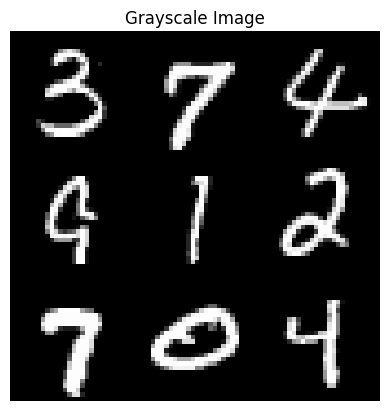

In [3]:
import torch
import matplotlib.pyplot as plt
for i in  train_loader:
    print(i[1].shape)
    image = i[0][0].squeeze(0)
    plt.imshow(image.numpy(), cmap='gray')
    plt.title("Grayscale Image")
    plt.axis('off')
    plt.show()
    break

## Building and training model

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the CNN model with one additional convolutional layer
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # [B, 16, 84, 84]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                # [B, 16, 42, 42]

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # [B, 32, 42, 42]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # [B, 32, 21, 21]

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # [B, 64, 21, 21]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # [B, 64, 10, 10]

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # [B, 128, 10, 10]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                  # [B, 128, 5, 5]
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                                          # [B, 128 * 5 * 5]
            nn.Linear(128 * 5 * 5, 128),
            nn.ReLU(),
            nn.Linear(128, 1),                                     # Output: 1 value per input
            nn.Sigmoid()                                           # Probability of class 1
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

def validate(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().to(device)

            # Forward pass
            outputs = model(images).squeeze(1)  # Shape: [batch_size]
            preds = (outputs > 0.5).float()  # Convert probabilities to 0/1 predictions

            # Metrics
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Validation Accuracy: {accuracy:.2f}%")
    return accuracy
#validate(model, val_loader)

# Training loop
def train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)

            # Forward pass
            outputs = model(images).squeeze(1)  # Shape: [batch_size]
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            epoch_loss += loss.item()
            preds = (outputs > 0.5).float()  # Convert probabilities to 0/1 predictions
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
        validate(model, val_loader)
# Assuming train_loader is defined elsewhere
train(model, train_loader, criterion, optimizer, epochs)


Epoch 1/10, Loss: 3563.0391, Accuracy: 60.00%
Validation Accuracy: 59.58%
Epoch 2/10, Loss: 3076.5616, Accuracy: 68.59%
Validation Accuracy: 65.74%
Epoch 3/10, Loss: 2782.2772, Accuracy: 72.95%
Validation Accuracy: 68.09%
Epoch 4/10, Loss: 2607.3927, Accuracy: 75.48%
Validation Accuracy: 73.17%
Epoch 5/10, Loss: 2419.5218, Accuracy: 78.19%
Validation Accuracy: 74.80%
Epoch 6/10, Loss: 2227.9731, Accuracy: 80.61%
Validation Accuracy: 77.94%
Epoch 7/10, Loss: 2085.3105, Accuracy: 82.35%
Validation Accuracy: 79.76%
Epoch 8/10, Loss: 1948.7472, Accuracy: 83.98%
Validation Accuracy: 81.20%
Epoch 9/10, Loss: 1851.5030, Accuracy: 85.00%
Validation Accuracy: 81.56%
Epoch 10/10, Loss: 1749.6211, Accuracy: 86.03%
Validation Accuracy: 82.95%


In [5]:
train(model, train_loader, criterion, optimizer, epochs)


Epoch 1/10, Loss: 1661.1536, Accuracy: 87.04%
Validation Accuracy: 83.58%
Epoch 2/10, Loss: 1585.8633, Accuracy: 87.75%
Validation Accuracy: 84.51%
Epoch 3/10, Loss: 1523.5592, Accuracy: 88.33%
Validation Accuracy: 83.71%
Epoch 4/10, Loss: 1460.7066, Accuracy: 88.91%
Validation Accuracy: 84.46%
Epoch 5/10, Loss: 1400.7753, Accuracy: 89.43%
Validation Accuracy: 85.30%
Epoch 6/10, Loss: 1339.6111, Accuracy: 90.04%
Validation Accuracy: 85.88%
Epoch 7/10, Loss: 1279.9729, Accuracy: 90.60%
Validation Accuracy: 85.43%
Epoch 8/10, Loss: 1231.9569, Accuracy: 90.97%
Validation Accuracy: 84.59%
Epoch 9/10, Loss: 1187.8932, Accuracy: 91.33%
Validation Accuracy: 86.12%
Epoch 10/10, Loss: 1147.2372, Accuracy: 91.66%
Validation Accuracy: 86.21%


In [6]:
train(model, train_loader, criterion, optimizer, epochs)

Epoch 1/10, Loss: 1113.7275, Accuracy: 91.95%
Validation Accuracy: 85.78%
Epoch 2/10, Loss: 1075.8730, Accuracy: 92.26%
Validation Accuracy: 86.15%
Epoch 3/10, Loss: 1043.1812, Accuracy: 92.46%
Validation Accuracy: 86.55%
Epoch 4/10, Loss: 1015.4976, Accuracy: 92.69%
Validation Accuracy: 86.70%
Epoch 5/10, Loss: 987.5673, Accuracy: 92.92%
Validation Accuracy: 85.81%
Epoch 6/10, Loss: 959.1143, Accuracy: 93.09%
Validation Accuracy: 87.14%
Epoch 7/10, Loss: 935.0854, Accuracy: 93.33%
Validation Accuracy: 86.49%
Epoch 8/10, Loss: 911.6684, Accuracy: 93.50%
Validation Accuracy: 85.74%
Epoch 9/10, Loss: 890.8595, Accuracy: 93.61%
Validation Accuracy: 87.02%
Epoch 10/10, Loss: 872.9096, Accuracy: 93.79%
Validation Accuracy: 86.27%


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score


def test(model, test_loader, num_classes):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.long().to(device)

            # Forward pass
            outputs = model(images).squeeze(1)  # Shape: [batch_size]
            preds = (outputs > 0.5).float()  # Convert probabilities to 0/1 predictions

            # Collect all predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays for metric calculations
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Metrics
    accuracy = 100 * (all_preds == all_labels).sum() / len(all_labels)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    # Per-class accuracy
    per_class_accuracy = []
    for cls in range(num_classes):
        class_indices = (all_labels == cls)
        class_correct = (all_preds[class_indices] == all_labels[class_indices]).sum()
        class_total = class_indices.sum()
        per_class_acc = 100 * class_correct / class_total if class_total > 0 else 0
        per_class_accuracy.append(per_class_acc)

    print(f"Test Metrics:")
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print("  Per-Class Accuracy:")
    for i, acc in enumerate(per_class_accuracy):
        print(f"    Class {i}: {acc:.2f}%")

    return accuracy, precision, recall, f1, per_class_accuracy

    
test(model, test_loader, 2)

Test Metrics:
  Accuracy: 87.13%
  Precision: 0.8699
  Recall:    0.8732
  F1 Score:  0.8715
  Per-Class Accuracy:
    Class 0: 86.94%
    Class 1: 87.32%


(87.13, 0.8698944012751544, 0.8732, 0.8715440662740792, [86.94, 87.32])

In [8]:
save_path = 'model.pth'
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to model.pth


# Let's load model after training and test the model

In [9]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # [B, 16, 84, 84]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                # [B, 16, 42, 42]

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # [B, 32, 42, 42]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # [B, 32, 21, 21]

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # [B, 64, 21, 21]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                 # [B, 64, 10, 10]

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # [B, 128, 10, 10]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                  # [B, 128, 5, 5]
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),                                          # [B, 128 * 5 * 5]
            nn.Linear(128 * 5 * 5, 128),
            nn.ReLU(),
            nn.Linear(128, 1),                                     # Output: 1 value per input
            nn.Sigmoid()                                           # Probability of class 1
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

from sklearn.metrics import precision_score, recall_score, f1_score

def test(model, test_loader, num_classes):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:
            device = 'cuda'
            images, labels = images.to(device), labels.long().to(device)

            # Forward pass
            outputs = model(images).squeeze(1)  # Shape: [batch_size]
            preds = (outputs > 0.5).float()  # Convert probabilities to 0/1 predictions

            # Collect all predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays for metric calculations
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Metrics
    accuracy = 100 * (all_preds == all_labels).sum() / len(all_labels)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    # Per-class accuracy
    per_class_accuracy = []
    for cls in range(num_classes):
        class_indices = (all_labels == cls)
        class_correct = (all_preds[class_indices] == all_labels[class_indices]).sum()
        class_total = class_indices.sum()
        per_class_acc = 100 * class_correct / class_total if class_total > 0 else 0
        per_class_accuracy.append(per_class_acc)

    print(f"Test Metrics:")
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1 Score:  {f1:.4f}")
    print("  Per-Class Accuracy:")
    for i, acc in enumerate(per_class_accuracy):
        print(f"    Class {i}: {acc:.2f}%")

    return accuracy, precision, recall, f1, per_class_accuracy

In [10]:
model = SimpleCNN()

model_path = '/kaggle/input/sudoku-model/model.pth'
model.load_state_dict(torch.load(model_path))
model = model.cuda()
model.eval()


/tmp/ipykernel_23/3297528494.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3200, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
)

In [11]:
test(model, test_loader, 2)

Test Metrics:
  Accuracy: 87.00%
  Precision: 0.8945
  Recall:    0.8389
  F1 Score:  0.8658
  Per-Class Accuracy:
    Class 0: 90.11%
    Class 1: 83.89%


(86.99666666666667,
 0.8945048695528542,
 0.8388666666666666,
 0.8657928234767951,
 [90.10666666666667, 83.88666666666667])

Real result: True
Prediction: tensor([1.], device='cuda:0')
probability value: tensor([0.8665], device='cuda:0', grad_fn=<SqueezeBackward1>)


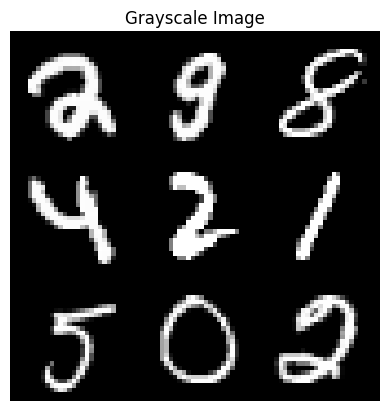

Real result: True
Prediction: tensor([0.], device='cuda:0')
probability value: tensor([5.3199e-15], device='cuda:0', grad_fn=<SqueezeBackward1>)


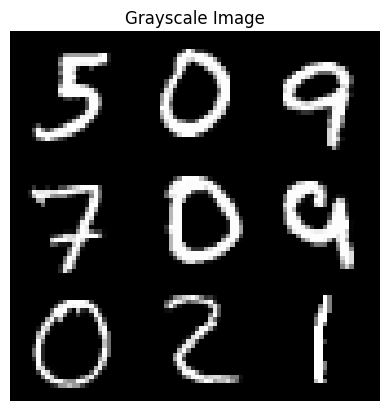

In [12]:
import torch
import matplotlib.pyplot as plt
one = 0
zero = 0
for img, label in  test_loader:
    image = img[1].squeeze(0)
    if one == 0 and label[0] == torch.tensor(True):
        one = 1
        result = model(img[1].unsqueeze(1).cuda()).squeeze(1)
        preds = (result > 0.5).float()
        print('Real result: True')
        print('Prediction:', preds)
        print('probability value:', result)
        plt.imshow(image.numpy(), cmap='gray')
        plt.title("Grayscale Image")
        plt.axis('off')
        plt.show()
    
    if zero == 0 and label[0] == torch.tensor(False):
        zero = 1
        result = model(img[1].unsqueeze(1).cuda()).squeeze(1)
        preds = (result > 0.5).float()
        print('Real result: True')
        print('Prediction:', preds)
        print('probability value:', result)
        plt.imshow(image.numpy(), cmap='gray')
        plt.title("Grayscale Image")
        plt.axis('off')
        plt.show()
    if zero == 1 and one == 1:
        break